# Bernstein-Vazirani Algorithm

---

**Microcredential:** Introduction to Quantum Computing  
**Period:** January 2026  

---
### Abstract
This notebook provides a implementation of the **Bernstein-Vazirani algorithm** using Qiskit. The project features a **parameterized architecture** capable $n$-qubit registers for any string length.

Components include:
* **Theoretical:** A mathematical breakdown of the quantum speed up.
* **Dynamic Oracle:** Automated circuit generation based on hidden bit strings.
* **Validation and Simulation:** Comprehensive testing using the `Aer` simulator with real world string to binary.



### Problem

Imagine a function $f$ that takes a string of bits ($x$) and spits out either 0 or 1. The function works by comparing the input $x$ to a secret bit string $s$. It's the sum (modulo 2) of each bit in $x$ multiplied by the bit in the same position in $s$.

$$f(x) = s \cdot x = (s_0x_0 \oplus s_1x_1 \oplus \dots \oplus s_{n-1}x_{n-1}) \pmod 2$$

The challenge is to guess the secret string $s$.

- Classical Method: A standard method needs $n$ questions to the function (checking $x = 100\dots, 010\dots, \dots$) to learn $s$.

- Quantum Method: The Bernstein-Vazirani method figures out $s$ with just 1 question.

The method uses something called phase kickback to put the result of $f(x)$ into the phase of a quantum state. Here is how it works:

1. Start: Set up $n$ qubits to $\lvert 0 \rangle$ and one more qubit to $\lvert - \rangle$:

$$\lvert \psi_0 \rangle = \lvert 0 \rangle^{\otimes n} \otimes \lvert - \rangle$$

2. Superposition: Put the first $n$ qubits into a superposition using $H^{\otimes n}$:

$$\lvert \psi_1 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} \lvert x \rangle \otimes \lvert - \rangle$$

3. Ask the Oracle: The oracle $U_f$ changes $\lvert x \rangle \lvert - \rangle$ to $(-1)^{f(x)} \lvert x \rangle \lvert - \rangle$:

$$\lvert \psi_2 \rangle = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} (-1)^{s \cdot x} \lvert x \rangle \otimes \lvert - \rangle$$

4. Interference: Run $H^{\otimes n}$ again, which turns the superposition into the hidden state $s$:

$$\lvert \psi_3 \rangle = H^{\otimes n} \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0,1\}^n} (-1)^{s \cdot x} \lvert x \rangle \right) = \lvert s \rangle$$



In [12]:
from IPython.display import clear_output

!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc
!pip install pandas

clear_output()
print("All dependencies installed successfully. Environment ready.")

All dependencies installed successfully. Environment ready.


In [13]:
%matplotlib inline

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

import matplotlib.pyplot as plt
import numpy as np

### How the Oracle Works

The dynamic oracle, or $U_{f}$, is key to the algorithm. It makes the function $f(x) = s \cdot x \pmod 2$ happen. In a quantum circuit, this means using an extra qubit to control operations.

To figure out the inner product quickly, the oracle is made like this:

1. Go through each bit in the hidden string $s$.
2. If a bit $s_i$ is '1', use a **CNOT** gate.
3. The $i$-th qubit of the input acts as the control, and the extra qubit is the target.

For one bit, the math is:

$$\text{If } s_i = 1 \implies \text{Use } CX(q_i, \text{ancilla})$$

This *kicks back* the phase $(-1)$ to the query register when the input bit and hidden bit match. This makes constructive interference helping in measuring $s$ later.


In [14]:
def algorithm_bv(qc, secret_string):
  """
    Function to constructs the Bernstein-Vazirani oracle dynamically.

    Args:
        qc (QuantumCircuit): The circuit to which the oracle will be added.
        secret_string (str): The hidden bitstring 's' to be encoded.

    Returns:
        qc (QuantumCircuit) : The circuit with the CX gates applied.
    """

  for qi, yesno in enumerate(reversed(secret_string)):
    if(yesno == '1'):
      qc.cx(qi, len(secret_string))
  return qc

In [15]:
def create_circuit(secret_string):
  """
  Function to create the quantum circuit for the Bernstein-Vazirani algorithm.

  Args:
      secret_string (str): The hidden bitstring 's' to be encoded.

  Returns:
      qc (QuantumCircuit): The quantum circuit for the algorithm.
      n (int): The number of qubits in the circuit (including the ancilla qubit)
  """

  n = len(secret_string)
  qc = QuantumCircuit(n + 1, n)

  qc.x(n)
  qc.h(range(n + 1))
  qc.barrier()

  qc = algorithm_bv(qc, secret_string)
  qc.barrier()

  qc.h(range(n))

  qc.measure(range(n),range(n))

  return qc, n

### Circuit setup
Here's a breakdown of the Bernstein-Vazirani algorithm circuit for finding a 4-bit hidden string. The process is split into three steps:

#### **- State preparation and superposition**

First, we set up our quantum register. The qubits ($q_0$ to $q_3$) start at $\lvert 0 \rangle$, then get transformed into an equal mix of states using Hadamard gates ($H^{\otimes n}$). At the same time, the ancilla qubit ($q_4$) is set to $\lvert - \rangle = \frac{1}{\sqrt{2}}(\lvert 0 \rangle - \lvert 1 \rangle)$ by using Pauli-$X$ and Hadamard gates in sequence. This setup is needed for the phase kickback part to work later.

#### **- Oracle run ($U_f$)**

Next, the oracle encodes the function $f(x) = s \cdot x \pmod 2$. The circuit design matches the secret string $s = 1011$, with $q_0$ as the Least Significant Bit (Little-Endian).

Here’s how it breaks down:

| Qubit index | Bit value ($s_i$) | Gate operation | What happens |
| :---: | :---: | :--- | :--- |
| **$q_0$** | $1$ | $CX(q_0, q_{anc})$ | Phase flip |
| **$q_1$** | $1$ | $CX(q_1, q_{anc})$ | Phase flip |
| **$q_2$** | $0$ | Identity ($I$) | No phase change |
| **$q_3$** | $1$ | $CX(q_3, q_{anc})$ | Phase flip |

> **Worth noting:** A missing Controlled-NOT gate on qubit $q_2$ means the bit at index 2 of the hidden string is zero. This shows how the phase kickback is selectively applied.

#### **- Measuring**

Finally, apply another set of Hadamard gates to the data. This makes the state matching the hidden string stand out, while others cancel out. This means that measuring will give us the bitstring `1011` every time, with a probability of $P(s) = 1$.

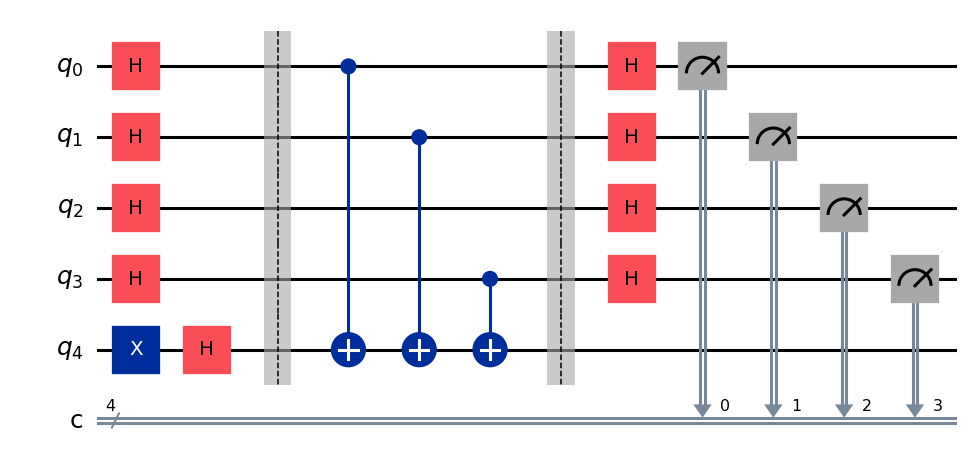

In [19]:
secret_string = '1011'

circuit, n_qubits = create_circuit(secret_string)

display(circuit.draw('mpl', style='iqp', scale=1.1, fold=-1))


##Testing implementation

This part shows how well the algorithm works by using it to process actual ASCII data. Unlike simple examples with short bitstrings, this test checks if the algorithm can handle different register sizes ($n$).

The testing process connects regular text with quantum states in three steps:

#### **Part 1: Turning text into quantum (Encoding)**

The system takes text ($S$), like the word *Quantum*. Each letter turns into an 8-bit binary code using ASCII/UTF-8. These codes combine into one long bitstring ($s_{total}$) with a length of $L$.

* **How it Changes:** $S \xrightarrow{\text{ASCII}} \{b_0, b_1, \dots, b_L\}$
* **How Many Qubits?:** The circuit sets up with $n = L$ qubits for the data, plus one extra qubit ($n+1$ total). So, a 5-letter word needs 40 qubits.

#### **Part 2: Running the code**

For each test, the **Bernstein-Vazirani** circuit is built right then. The oracle ($U_f$) puts the whole text string into the quantum state.

* **Simulator:** `Aer Simulator`
* **Number of Runs:** $N_{shots} = 1$
* **Why It Matters:** Since the algorithm always gives the right answer, one run should be enough to get the info back perfectly ($P(s)=1$). Regular methods would need $L$ tries to get the string bit by bit.

#### **Part 3: Checking the answer**

The output is a binary string ($m$). The system splits $m$ into 8-bit pieces, turns them into numbers, and changes them back into ASCII letters to rebuild the string ($S'$).

* **Did It Work?:** The test passes if $S'$ is the same as $S$.

The table shows the results for different words, with different lengths.

In [18]:
import binascii
import pandas
from IPython.display import display, HTML

string_words = ["Hello", "Qiskit", "Quantum", "Logic", "Bits", "101", "Physics", "Bernstein"]
bin_words = list(map(lambda w: ''.join(format(ord(char), '08b') for char in w), string_words))

simulator = AerSimulator()
df_results = pandas.DataFrame(columns=["CIRCUIT SIZE", "TARGET WORD", "DECODED RESULT" , "EXPECTED BINARY", "RAW MEASUREMENT"])

for original_text, binary_secret in zip(string_words, bin_words):
    qc, n = create_circuit(binary_secret)

    job = simulator.run(qc, shots=1)
    counts = job.result().get_counts()
    read_binary = list(counts.keys())[0]

    n_bytes = int(read_binary, 2).to_bytes((len(read_binary) + 7) // 8, byteorder='big')
    try:
        recover_text = n_bytes.decode('utf-8', errors='ignore')
        df_results.loc[len(df_results)] = [n,original_text,recover_text , binary_secret, read_binary]
    except:
        recover_text = "[Error decoding string]"

df_results['STATE'] = df_results.apply(
    lambda row: "CORRECT" if row["EXPECTED BINARY"] == row["RAW MEASUREMENT"] else "ERROR",
    axis=1
)

styled_table = df_results.style.set_table_attributes('style="width:90%; border-collapse: collapse; text-align:center;"') \
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('border-top', '2px solid #777'),
            ('border-bottom', '2px solid #777'),
            ('padding', '12px 5px'),
            ('text-align', 'center'),
            ('font-size', '13px'),
            ('text-transform', 'uppercase')
        ]},
        {'selector': 'td', 'props': [
            ('padding', '10px 5px'),
            ('border-bottom', '1px solid #44444433'),
            ('text-align', 'center'),
            ('font-family', 'monospace'),
            ('font-size', '14px')
        ]},
    ]) \
    .map(lambda v: 'color: #2e7d32; font-weight: bold;' if v == "CORRECT" else ('color: #c62828; font-weight: bold;' if v == "ERROR" else ''), subset=['STATE'])

display(HTML("""
    <div style="font-family: sans-serif; color: #333; padding: 10px 0; border-bottom: 2px solid #777; width: 100%; margin-bottom: 10px; text-align:center">
        <span style="font-size: 18px; font-weight: bold; letter-spacing: 1px;">
            ADVANCED DEMONSTRATION: TEXT DECODING
        </span>
    </div>
"""))

display(styled_table)

,CIRCUIT SIZE,TARGET WORD,DECODED RESULT,EXPECTED BINARY,RAW MEASUREMENT,STATE
0,40,Hello,Hello,0100100001100101011011000110110001101111,0100100001100101011011000110110001101111,CORRECT
1,48,Qiskit,Qiskit,010100010110100101110011011010110110100101110100,010100010110100101110011011010110110100101110100,CORRECT
2,56,Quantum,Quantum,01010001011101010110000101101110011101000111010101101101,01010001011101010110000101101110011101000111010101101101,CORRECT
3,40,Logic,Logic,0100110001101111011001110110100101100011,0100110001101111011001110110100101100011,CORRECT
4,32,Bits,Bits,01000010011010010111010001110011,01000010011010010111010001110011,CORRECT
5,24,101,101,001100010011000000110001,001100010011000000110001,CORRECT
6,56,Physics,Physics,01010000011010000111100101110011011010010110001101110011,01010000011010000111100101110011011010010110001101110011,CORRECT
7,72,Bernstein,Bernstein,010000100110010101110010011011100111001101110100011001010110100101101110,010000100110010101110010011011100111001101110100011001010110100101101110,CORRECT
